In [1]:
import pandas as pd
import networkx as nx
import networkx.algorithms as nx_alg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('enron-all.csv')
df.rename(columns = {'Source': 'source', 'Target': 'target'}, inplace = True)
df.head()

,source,target
0,steven.kean,maureen.mcvicker
1,d..steffes,paul.kaufman
2,james.steffes,richard.shapiro
3,james.steffes,steven.kean
4,james.steffes,paul.kaufman


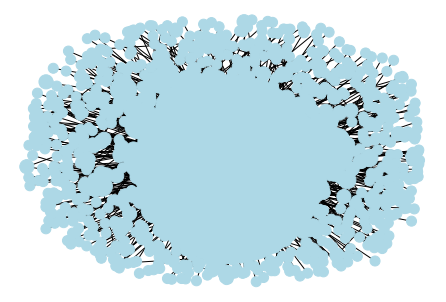

In [3]:
graph = nx.convert_matrix.from_pandas_edgelist(df)
pos = nx.spring_layout(graph, k=0.15, iterations=20)
d = nx.degree(graph)
nx.draw(graph, pos = pos, nodelist=[k[0] for k in d], node_size=[v[1] * 100 for v in d], node_color = 'lightblue')
plt.show()

Not a greatly helpful graph. Let's move on to compute the nodes with the highest centralities.

In [4]:
degree_centralities = nx_alg.centrality.degree_centrality(graph)
for name, centrality in degree_centralities.items():
    if centrality == max([value for key, value in degree_centralities.items()]):
        print(name, ":", centrality)

steven.kean : 0.32120109190172885


In [5]:
eigenvector_centralities = nx_alg.centrality.eigenvector_centrality(graph)
for name, centrality in eigenvector_centralities.items():
    if centrality == max([value for key, value in eigenvector_centralities.items()]):
        print(name, ":", centrality)

steven.kean : 0.5685579518376193


In [6]:
closeness_centralities = nx_alg.centrality.closeness_centrality(graph)
for name, centrality in closeness_centralities.items():
    if centrality == max([value for key, value in closeness_centralities.items()]):
        print(name, ":", centrality)

steven.kean : 0.4096599453906011


In [7]:
betweenness_centralities = nx_alg.centrality.betweenness_centrality(graph)
for name, centrality in betweenness_centralities.items():
    if centrality == max([value for key, value in betweenness_centralities.items()]):
        print(name, ":", centrality)

steven.kean : 0.706978496671905


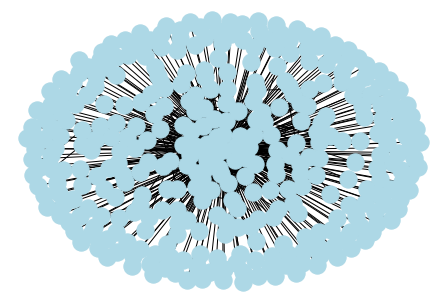

In [8]:
ego_graph = nx.generators.ego.ego_graph(graph, radius = 1, center = True, n = 'steven.kean')
pos = nx.spring_layout(ego_graph, k=0.15, iterations=20)
nx.draw(ego_graph, pos = pos, node_color = 'lightblue')
plt.show()

Still not a greatly helpful visualization, but let's take a look at the cliques now.

In [9]:
cliques = [x for x in nx_alg.clique.enumerate_all_cliques(ego_graph)]
biggest_cliques = []
for clique in cliques:
    if len(clique) == max([len(c) for c in cliques]):
        biggest_cliques.append(clique)
        
biggest_cliques

[['steven.kean',
  'jeff.dasovich',
  'karen.denne',
  'mary.hain',
  'paul.kaufman',
  'alan.comnes',
  'susan.mara',
  'james.steffes'],
 ['steven.kean',
  'jeff.dasovich',
  'karen.denne',
  'mary.hain',
  'alan.comnes',
  'susan.mara',
  'richard.shapiro',
  'james.steffes'],
 ['steven.kean',
  'jeff.dasovich',
  'mary.hain',
  'tom.hoatson',
  'alan.comnes',
  'susan.mara',
  'richard.shapiro',
  'james.steffes'],
 ['steven.kean',
  'jeff.dasovich',
  'tom.hoatson',
  'alan.comnes',
  'susan.mara',
  'john.shelk',
  'richard.shapiro',
  'james.steffes']]

In [10]:
biggest_influencers = list(set(biggest_cliques[0]).intersection(*biggest_cliques))
for influencer in biggest_influencers:
    print(influencer)

susan.mara
james.steffes
jeff.dasovich
alan.comnes
steven.kean


Let's take a look at the density of the graph.

In [11]:
density_df = pd.DataFrame()
for node, degree in graph.degree():
    ego_graph = nx.generators.ego.ego_graph(graph, node, radius = 1, center = True)
    density = nx.classes.function.density(ego_graph)
    benchmark_density = density * len(ego_graph.nodes)

    density_df = density_df.append(pd.DataFrame(
        {
            'node': [node],
            "degree": [len(ego_graph.nodes)],
            'ego graph density': [density],
            'benchmark density': [benchmark_density]
        }
    ))

density_df.sort_values(by = "benchmark density", ascending = False, inplace = True)
print(density_df.head())

                  node  degree  ego graph density  benchmark density
0        james.steffes      23           0.478261          11.000000
0           tim.belden      13           0.769231          10.000000
0        sarah.novosel      15           0.657143           9.857143
0          tom.hoatson      15           0.647619           9.714286
0  gfergus@brobeck.com      20           0.478947           9.578947


Next, we'll look at the emails exchanged with Seven Kean and others, and we will create a tie strength based on the number of emails both sent and received.

In [12]:
df = pd.read_csv('email_adjacency.csv')
df.rename(columns = {'Source': 'source', 'Target': 'target'}, inplace = True)
print(df.head())

            source                       target  count
0     3e@enron.com  scott.hendrickson@enron.com      1
1  4.ews@enron.com              4.ews@enron.com      1
2  4.ews@enron.com      andrew.edison@enron.com      1
3  4.ews@enron.com      chris.hilgert@enron.com      1
4  40ect@enron.com      Tammy.Gilmore@enron.com      1


In [13]:
to_steven_df = df.loc[df['target'].str.contains('steven.kean')]
to_steven_df.sort_values(by = "count", ascending = False, inplace = True)
to_steven_df['received_tie_strength'] = to_steven_df['count'] / to_steven_df['count'].max()
to_steven_df.rename(columns = {'source': 'connection', 'count': 'Emails Received'}, inplace = True)
to_steven_df.drop("target", axis = 1, inplace = True)
print(to_steven_df.head())

                      connection  Emails Received  received_tie_strength
51147  richard.shapiro@enron.com              461               1.000000
23718    james.steffes@enron.com              334               0.724512
40632   mark.schroeder@enron.com              264               0.572668
55377    sarah.novosel@enron.com              207               0.449024
40512      mark.palmer@enron.com              197               0.427332


In [14]:
from_steven_df = df.loc[df['source'].str.contains('steven.kean')]
from_steven_df.sort_values(by = "count", ascending = False, inplace = True)
from_steven_df['sent_tie_strength'] = from_steven_df['count'] / from_steven_df['count'].max()
from_steven_df.rename(columns = {'target': 'connection', 'count': 'Emails Sent'}, inplace = True)
from_steven_df.drop("source", axis = 1, inplace = True)
print(from_steven_df.head())

                        connection  Emails Sent  sent_tie_strength
59864   maureen.mcvicker@enron.com         1038           1.000000
59775      jeff.dasovich@enron.com          348           0.335260
59914    richard.shapiro@enron.com          265           0.255299
59723  elizabeth.linnell@enron.com          205           0.197495
59834    linda.robertson@enron.com          200           0.192678


In [15]:
combined_df = to_steven_df.merge(from_steven_df, on = 'connection', how = "outer")
combined_df['composite_tie_strength'] = (combined_df['Emails Sent'] * combined_df['sent_tie_strength']) + (combined_df['Emails Received'] * combined_df['received_tie_strength'])
combined_df['composite_tie_strength'] = combined_df['composite_tie_strength'] / (combined_df['Emails Received'] + combined_df['Emails Sent'])
combined_df.sort_values(by = "composite_tie_strength", ascending = False, inplace = True)
print(combined_df.head())

                   connection  Emails Received  received_tie_strength  \
7  maureen.mcvicker@enron.com            162.0               0.351410   
0   richard.shapiro@enron.com            461.0               1.000000   
1     james.steffes@enron.com            334.0               0.724512   
2    mark.schroeder@enron.com            264.0               0.572668   
3     sarah.novosel@enron.com            207.0               0.449024   

   Emails Sent  sent_tie_strength  composite_tie_strength  
7       1038.0           1.000000                0.912440  
0        265.0           0.255299                0.728174  
1        157.0           0.151252                0.541209  
2        123.0           0.118497                0.428319  
3         51.0           0.049133                0.369976  
